Import libraries

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Importing neccessary functions

# Plot 
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    

    plt.grid(True)

# Display trend
def trend(time, slope=0): 
  return slope*time

# Display trend by season - go with seasonality
def seasonal_pattern(season_time): 
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi), 
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0): 
  season_time = ((time+phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


# Display noise
def noise(time, noise_level=1, seed=None): 
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-10-29 15:36:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-10-29 15:36:56 (4.79 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [ ]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

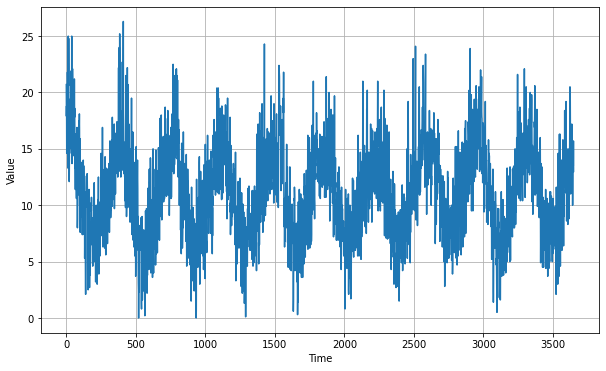

In [ ]:
import csv
time_step = []
temps = []
real_time = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    real_time.append(row[0])
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

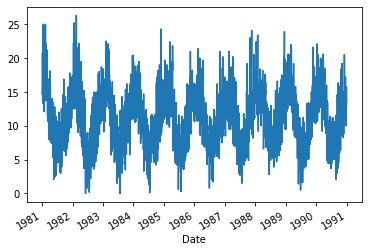

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
data = read_csv('/tmp/daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
data.plot()
pyplot.show()

In [ ]:
df_targets= data.shift(-shift_steps)

In [ ]:
df_targets.tail()

Date
1990-12-27   NaN
1990-12-28   NaN
1990-12-29   NaN
1990-12-30   NaN
1990-12-31   NaN
Name: Temp, dtype: float64

In [ ]:
x_data = data.values[0:-shift_steps]

In [ ]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (3626,)


In [ ]:
y_data = df_targets.values[:-shift_steps]

In [ ]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (3626,)


In [ ]:
num_data = len(x_data)
num_data

3626

In [ ]:
train_split = 0.9

In [ ]:
num_train = int(train_split * num_data)
num_train

num_test = num_data - num_train
num_test

363

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

3626

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

3626

In [ ]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
x_train

array([20.7, 17.9, 18.8, ...,  9.6, 10.8, 12.1])

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    print(ds)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    print(ds)

    ds = ds.flat_map(lambda w: w.batch(window_size))
    print(ds)

    ds = ds.batch(32).prefetch(1)
    print(ds)
    
    forecast = model.predict(ds)
    return forecast

In [ ]:
series

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Temp, Length: 3650, dtype: float64

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional
from tensorflow.keras.backend import clear_session

In [ ]:
clear_session()

In [ ]:
clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 28ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 0s 26ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 0s 28ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 0s 28ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

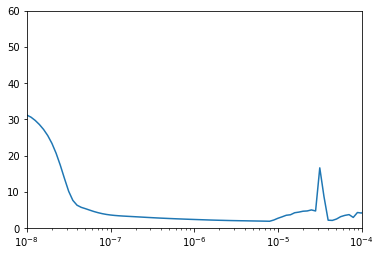

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 0s 16ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/150
25/25 [==============================] - 0s 16ms/step - loss: 2.5295 - mae: 2.9923
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 1.9503 - mae: 2.4047
Epoch 4/150
25/25 [==============================] - 0s 15ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 0s 14ms/step - loss: 1.8214 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 0s 15ms/step - loss: 1.7908 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 0s 16ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 0s 15ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 0s 16ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 0s 16ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [============================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


<TensorSliceDataset shapes: (1,), types: tf.float64>
<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<FlatMapDataset shapes: (None, 1), types: tf.float64>
<PrefetchDataset shapes: (None, None, 1), types: tf.float64>


In [ ]:
series

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Name: Temp, Length: 3650, dtype: float64

In [ ]:
series[..., np.newaxis]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13. ]])

In [ ]:
test = tf.data.Dataset.from_tensor_slices(series[..., np.newaxis])
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


<TensorSliceDataset shapes: (1,), types: tf.float64>

In [ ]:
test = test.window(window_size, shift=1, drop_remainder=True)
test

<WindowDataset shapes: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([])), types: DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>

In [ ]:
split_time - window_size

2480

In [ ]:
rnn_forecast

array([11.304873 , 10.694763 , 12.027168 , ..., 13.302253 , 13.4515505,
       14.739156 ], dtype=float32)

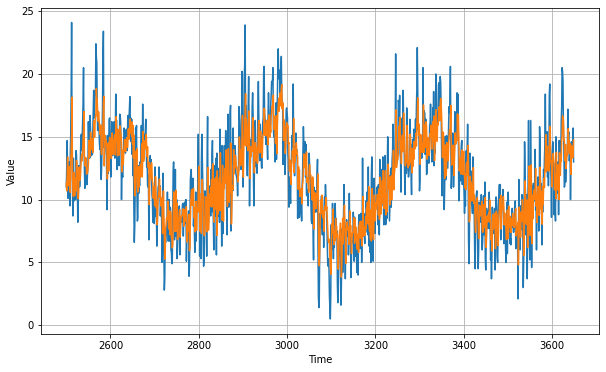

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


1.7796389

In [ ]:
print(rnn_forecast)


[11.327929 10.704949 12.123797 ... 13.603867 13.795985 15.008309]


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64


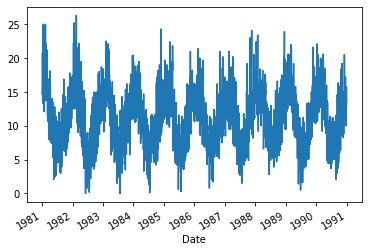

In [ ]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
series = read_csv('/tmp/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, timesteps):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], timesteps, 1)
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, len(X), 1)
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# run a repeated experiment
def experiment(repeats, series, timesteps):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, timesteps)
	supervised_values = supervised.values[timesteps:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1, timesteps)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores

# execute the experiment
def run():
	# load dataset
	series = read_csv('/tmp/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	timesteps = 1
	results['results'] = experiment(repeats, series, timesteps)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_timesteps_1.csv', index=False)

 # entry point
run()

KeyboardInterrupt: ignored